# Test clip

In [1]:
import torch
import clip
from PIL import Image
import numpy as np
import cv2
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [2]:
# Load the data
model, preprocess = clip.load("RN50", device=device)
# print("model:", model.input_resolution.item())


In [11]:
print(clip.available_models())

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


## how CLIPort encode image
prepool_im() in class ModifiedResNet(nn.Module) in clip.py

out_put size [1, 2048, 10, 5]

In [5]:
image_name = "image_record/assembling-kitsn_0step0.png"
image = cv2.imread(image_name)

image = image.transpose((2, 0, 1))
image = torch.tensor(image, dtype=torch.float32).reshape(1,image.shape[0],image.shape[1],image.shape[2]).to(device)

from cliport.models.clip_lingunet import CLIPLingUNet
from cliport.utils import utils
from cliport.models.core.clip import build_model, load_clip, tokenize
def _load_clip(device):
    model, _ = load_clip("RN50", device=device)
    clip_rn50 = build_model(model.state_dict()).to(device)
    del model
    return clip_rn50
clip_rn50 = _load_clip(device)
def encode_image(clip_rn50,img):
    with torch.no_grad():
        img_encoding, img_im = clip_rn50.visual.prepool_im(img)
    return img_encoding, img_im

In [64]:
image = utils.preprocess(image, dist='clip')
# image1_features = clip_rn50.encode_image(image)
image1_features,_ =encode_image(clip_rn50,image)
print(image.shape)
print(image1_features.shape)

torch.Size([1, 3, 320, 160])
torch.Size([1, 2048, 10, 5])


In [14]:
image1 = preprocess(Image.open("sdh1.png")).unsqueeze(0).to(device)
image2 = preprocess(Image.open("sdh2.png")).unsqueeze(0).to(device)
image3 = preprocess(Image.open("sdh3.png")).unsqueeze(0).to(device)
image4 = preprocess(Image.open("camera manipulator1.png")).unsqueeze(0).to(device)
text = clip.tokenize(["an opened robot hand", "a closed robot hand", "a cat"]).to(device)

In [15]:

image1_features = model.encode_image(image1)
image2_features = model.encode_image(image2)
image3_features = model.encode_image(image3)
image4_features = model.encode_image(image4)
print(len(image1_features[0]))
image1_features /= image1_features.norm(dim=-1, keepdim=True)
image2_features /= image2_features.norm(dim=-1, keepdim=True)
image3_features /= image3_features.norm(dim=-1, keepdim=True)
image4_features /= image4_features.norm(dim=-1, keepdim=True)
images = [image1, image2, image3, image4]
images_features = [image1_features, image2_features, image3_features, image4_features]
sim_mat = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        sim_mat[i,j] = images_features[i] @ images_features[j].T

print(sim_mat)

1024
[[0.99902344 0.97021484 0.93457031 0.63330078]
 [0.97021484 1.         0.94580078 0.63037109]
 [0.93457031 0.94580078 0.99951172 0.60742188]
 [0.63330078 0.63037109 0.60742188 1.00097656]]


In [47]:
with torch.no_grad():
    for image in images:
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[4.5703e-01 5.4297e-01 1.1575e-04]]
Label probs: [[4.338e-01 5.659e-01 7.915e-05]]
Label probs: [[3.923e-01 6.074e-01 9.626e-05]]
Label probs: [[2.815e-01 7.188e-01 2.801e-06]]


## TEST in CLIPort



In [4]:
# 1 episode different stage
task_name = "stack-block-pyramid-seq-seen-colors"
ep_id = 0
image_names = ["image_record/"+task_name+'n_'+str(ep_id)+'step'+str(i)+'.png' for i in range(7)]
images = [preprocess(Image.open(image_name)).unsqueeze(0).to(device) for image_name in image_names]
image_features = [model.encode_image(image) for image in images]
image_features = [image_feature/image_feature.norm(dim=-1, keepdim=True) for image_feature in image_features]


In [5]:
num = len(image_features)
sim_mat = np.zeros((num,num))
for i in range(num):
    for j in range(num):
        sim_mat[i,j] = image_features[i] @ image_features[j].T

print(sim_mat)

[[0.99999946 0.98593503 0.98746449 0.97904754 0.98013985 0.97170478
  0.98805588]
 [0.98593503 1.00000036 0.99654639 0.99122798 0.99516851 0.98802638
  0.99758804]
 [0.98746449 0.99654639 1.00000083 0.98529696 0.99206954 0.98174703
  0.99681866]
 [0.97904754 0.99122798 0.98529696 1.00000036 0.99379009 0.99554121
  0.99111599]
 [0.98013985 0.99516851 0.99206954 0.99379009 0.99999976 0.99153864
  0.99695808]
 [0.97170478 0.98802638 0.98174703 0.99554121 0.99153864 1.00000072
  0.98806453]
 [0.98805588 0.99758804 0.99681866 0.99111599 0.99695808 0.98806453
  0.99999952]]


In [10]:
# 1 episode different stage
task_name = "stack-block-pyramid-seq-seen-colors"
ep_id = 1
# image_names = ["image_record/"+task_name+'n_'+str(ep_id)+'step'+str(i)+'.png' for i in range(6)]
image_names = ["image_record/"+task_name+'n_'+str(i)+'step'+str(0)+'.png' for i in range(6)]
images = [preprocess(Image.open(image_name)).unsqueeze(0).to(device) for image_name in image_names]
image_features = [model.encode_image(image) for image in images]
image_features = [image_feature/image_feature.norm(dim=-1, keepdim=True) for image_feature in image_features]

In [11]:
num = len(image_features)
sim_mat = np.zeros((num,num))
for i in range(num):
    for j in range(num):
        sim_mat[i,j] = image_features[i] @ image_features[j].T

print(sim_mat)

[[0.99999946 0.9258256  0.88833207 0.90622616 0.80493432 0.83917588]
 [0.9258256  1.00000095 0.94478595 0.97157902 0.94428623 0.95867586]
 [0.88833207 0.94478595 1.00000048 0.94958198 0.90626055 0.95097524]
 [0.90622616 0.97157902 0.94958198 0.99999994 0.94750768 0.96925819]
 [0.80493432 0.94428623 0.90626055 0.94750768 1.         0.97149122]
 [0.83917588 0.95867586 0.95097524 0.96925819 0.97149122 1.00000048]]


In [12]:
text = clip.tokenize(["five blocks on the table", "six blocks on the table"]).to(device)
with torch.no_grad():
    for image in images:
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.49248514 0.5075149 ]]
Label probs: [[0.516957   0.48304304]]
Label probs: [[0.46220043 0.5377996 ]]
Label probs: [[0.5732114 0.4267886]]
Label probs: [[0.6207339  0.37926614]]
Label probs: [[0.5521341  0.44786584]]


In [11]:
image_names = [["image_record/assembling-kitsn_0step0.png","image_record/assembling-kitsn_0step1.png"],
               ["image_record/assembling-kitsn_1step3.png","image_record/assembling-kitsn_1step4.png"],
               ["image_record/assembling-kitsn_2step2.png","image_record/assembling-kitsn_2step3.png"],]

images = [[preprocess(Image.open(image_name)).unsqueeze(0).to(device) for image_name in _image_names] for _image_names in image_names]
text = clip.tokenize(["L shape block in L shape hole", "L shape block not in L shape hole"]).to(device)
with torch.no_grad():
    for _images in images:
        for image in _images:
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)
            
            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

            print("Label probs:", probs)
        image_features = [model.encode_image(image) for image in _images]
        image_features = [image_feature/image_feature.norm(dim=-1, keepdim=True) for image_feature in image_features]
        print("cosine similarity:", image_features[0] @ image_features[1].T)

Label probs: [[0.3074 0.693 ]]
Label probs: [[0.3208 0.679 ]]
cosine similarity: tensor([[0.9741]], device='cuda:0', dtype=torch.float16)
Label probs: [[0.3174 0.6826]]
Label probs: [[0.304 0.696]]
cosine similarity: tensor([[0.9771]], device='cuda:0', dtype=torch.float16)
Label probs: [[0.2751 0.725 ]]
Label probs: [[0.3486 0.6514]]
cosine similarity: tensor([[0.9795]], device='cuda:0', dtype=torch.float16)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


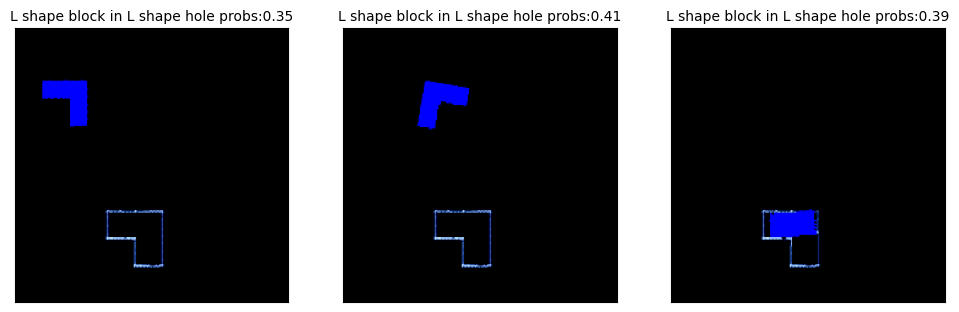

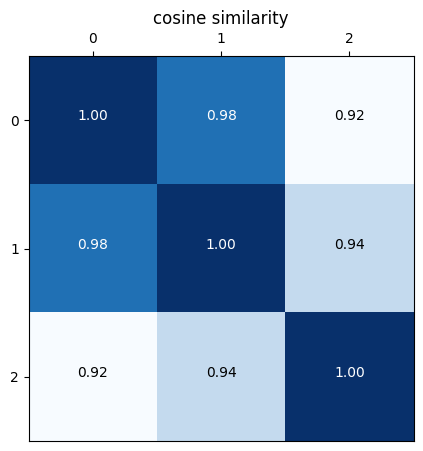

In [8]:
import itertools
import matplotlib.pyplot as plt
image_names = ["image_record/block-insertion-translationn_6step0.png","image_record/block-insertion-translationn_6step1.png","image_record/block-insertion-translationn_6step2.png"]
# images = [preprocess(Image.open(image_name)).unsqueeze(0).to(device) for image_name in image_names]
images = [cv2.imread(image_name) for image_name in image_names]
# null_image = np.ones_like(images[0][:,:80,:])*45
# images = [np.hstack([null_image,image,null_image]) for image in images]
images = [image[160:,:,:] for image in images]
text = clip.tokenize(["L shape block in L shape hole", "L shape block not in L shape hole"]).to(device)
images = [preprocess(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))).unsqueeze(0).to(device) for image in images]
with torch.no_grad():

    fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,1*4))
    images_features = []
    # show clip label
    for i in range(3):
        # print(image)
        with torch.no_grad():
            image_features = model.encode_image(images[i])
            images_features.append(image_features)
            # text_features = model.encode_text(text)
            # print("image_features.shape:",image_features.shape)
            logits_per_image, logits_per_text = model(images[i], text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            ax[i].imshow(images[i][0].cpu().numpy().transpose(1,2,0))
            ax[i].set_title("L shape block in L shape hole"+" probs:"+"%.2f"%probs[0][0],fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])


    # plt.show()
    sim_mat = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            sim_mat[i][j] = torch.cosine_similarity(images_features[i],images_features[j],dim=-1).cpu().numpy()[0]
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
    
    np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
    ax1.imshow(sim_mat,cmap=plt.cm.Blues)
    ax1.set_title("cosine similarity")
    ax1.set_xticks(np.arange(3))
    ax1.set_yticks(np.arange(3))
    fmt = '.2f'
    thresh = (sim_mat.max() + sim_mat.min())/ 2.
    for i, j in itertools.product(range(sim_mat.shape[0]), range(sim_mat.shape[1])):
        plt.text(j, i, format(sim_mat[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if sim_mat[i, j] > thresh else "black"
                 )

In [32]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(x):
    interact(g, y=fruits[x]);
def g(y):
    print(y)
fruits = [['apple','apples'],['orange','oranges']]
interact(f, x=[0,1]);

interactive(children=(Dropdown(description='x', options=(0, 1), value=0), Output()), _dom_classes=('widget-int…

In [29]:
a = widgets.IntSlider()
b = widgets.IntSlider()
c = widgets.IntSlider()
ui = widgets.HBox([a, b, c])
def f(a, b, c):
    print((a, b, c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

display(ui, out)

Output()

In [9]:
import itertools
tasks = ["assembling-kits",
         "stack-block-pyramid-seq-seen-colors",
         "align-box-corner",
         "sweeping-piles",
         "block-insertion"]
_task_eplen = [
    5,
    6,
    2,
    9,
    2,
]
task_eplen = {tasks[i]:_task_eplen[i] for i in range(len(tasks))}

text = [
"all blocks are on the hole",
"blocks stacked on the blocks",
"blocks are aligned with the corner",
"piles are swept into the square",
"block is inserted into the L-shape hole",
]
text_tokens = {}
text_tokens["all blocks are on the hole"] = clip.tokenize(["all blocks are on the hole", "all blocks are not on the hole"]).to(device)
text_tokens["blocks stacked on the blocks"] = clip.tokenize(["blocks stacked on the blocks", "blocks not stacked on the blocks"]).to(device)
text_tokens["blocks are aligned with the corner"] = clip.tokenize(["blocks are aligned with the corner", "blocks are not aligned with the corner"]).to(device)
text_tokens["piles are swept into the square"] = clip.tokenize(["piles are swept into the square", "piles are not swept into the square"]).to(device)
text_tokens["block is inserted into the L-shape hole"] = clip.tokenize(["block is inserted into the L-shape hole", "block is not inserted into the L-shape hole"]).to(device)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
def plot_clip_understanding(task_name,ep_id,text_label):
    # print("task_name:",task_name)
    # print("ep_id:",ep_id)
    # print("text_label:",text_label)
    image_names = ["image_record/"+task_name+'n_'+str(ep_id)+'step'+str(i)+'.png' for i in range(task_eplen[task_name])]
    
    images = [cv2.imread(image_name) for image_name in image_names]
    null_image = np.ones_like(images[0][:,:80,:])*45
    images = [np.hstack([null_image,image,null_image]) for image in images]
    images = [preprocess(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))).unsqueeze(0).to(device) for image in images]
    text = text_tokens[text_label]
    rows = (task_eplen[task_name]-1)//3+1
    fig,ax = plt.subplots(nrows=rows,ncols=3,figsize=(12,rows*4))
    images_features = []
    # show clip label
    for i in range(task_eplen[task_name]):
        # print(image)
        with torch.no_grad():
            image_features = model.encode_image(images[i])
            images_features.append(image_features)
            # text_features = model.encode_text(text)
            # print("image_features.shape:",image_features.shape)
            logits_per_image, logits_per_text = model(images[i], text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            if rows==1:
                ax[i].imshow(images[i][0].cpu().numpy().transpose(1,2,0))
                ax[i].set_title(text_label[:30]+" probs:"+"%.2f"%probs[0][0],fontsize=10)
                ax[i].set_xticks([])
                ax[i].set_yticks([])
            else:
                ax[i//3][i%3].imshow(images[i][0].cpu().numpy().transpose(1,2,0))
                ax[i//3][i%3].set_title(text_label[:30]+" probs:"+"%.2f"%probs[0][0],fontsize=10)
                ax[i//3][i%3].set_xticks([])
                ax[i//3][i%3].set_yticks([])
            # print("Label probs:", probs)

    # plt.show()
    sim_mat = np.zeros((task_eplen[task_name],task_eplen[task_name]))
    for i in range(task_eplen[task_name]):
        for j in range(task_eplen[task_name]):
            sim_mat[i][j] = torch.cosine_similarity(images_features[i],images_features[j],dim=-1).cpu().numpy()[0]
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
    
    np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
    ax1.imshow(sim_mat,cmap=plt.cm.Blues)
    ax1.set_title("cosine similarity")
    ax1.set_xticks(np.arange(task_eplen[task_name]))
    ax1.set_yticks(np.arange(task_eplen[task_name]))
    fmt = '.2f'
    thresh = (sim_mat.max() + sim_mat.min())/ 2.
    for i, j in itertools.product(range(sim_mat.shape[0]), range(sim_mat.shape[1])):
        plt.text(j, i, format(sim_mat[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if sim_mat[i, j] > thresh else "black"
                 )
    # show cosine similarity

        
interact(plot_clip_understanding, task_name=tasks, ep_id=range(0,10), text_label=text);

interactive(children=(Dropdown(description='task_name', options=('assembling-kits', 'stack-block-pyramid-seq-s…